### Importing Libraries

In [1]:
#Importing required libraries
import os
import json
import urllib
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, History
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
#Creating a folder to save models
os.mkdir('resnet')

In [3]:
#Creating a funciton which sets layers to non trainable if required
def non_trainable(model):
    for i in range(len(model.layers)):
      model.layers[i].trainable = False
    return model

In [4]:
#Plotting metrics for neural networks models
def plot_metrics(nn_model,metric):
  plt.figure(figsize = (10,5))
  plt.plot(nn_model.history.history[metric])
  plt.plot(nn_model.history.history['val_'+metric])
  plt.title('model '+metric)
  plt.ylabel(metric)
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  idx = np.argmax(nn_model.history.history['val_accuracy'])
  print('The '+metric+' for final model is ',nn_model.history.history['val_'+metric][idx])

In [5]:
#Plotting confusion matrix
def binary_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  print("-"*50, "Confusion matrix", "-"*50)
  cmap=sns.light_palette("blue")
  plt.figure(figsize=(10,5))
  sns.heatmap(Cm, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels_list, yticklabels=labels_list)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

In [6]:
def multiclass_confusion_matrix(true_y,pred_y,labels_list):
  Cm = confusion_matrix(true_y,pred_y)
  Pm = (Cm/Cm.sum(axis = 0))
  Rm = (((Cm.T)/(Cm.sum(axis =1))).T)
  cmap = sns.light_palette('blue')
  mt = [Cm,Pm,Rm]
  names = ['Confusion Matrix','Precision Matrix','Recall Matrix']
  print('Average Precision is',np.trace(Pm)/3)
  print('Average Recall is',np.trace(Rm)/3)
  for i in range(len(mt)):
    print('-'*50,names[i],'-'*50)
    plt.figure(figsize = (10,5))
    sns.heatmap(mt[i],annot = True,cmap = cmap,fmt = ".3f",xticklabels = labels_list,yticklabels = labels_list)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [7]:
def compute_precision_recall(true_y,true_pred):
  tp,fn,fp,tn = confusion_matrix(true_y,true_pred).ravel()
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  return precision,recall

In [8]:
resnet_scores = pd.DataFrame(columns = ['Model','Accuracy','Precision','Recall'])

# Orginal Data

In [9]:
#Data for Neural Networks
input_shapes = (256,256,3)
batch_size = 8

In [10]:
#Classes
stage1_class_labels = ['damaged','not_damaged']
stage2_class_labels = ['front','rear','side']
stage3_class_labels = ['minor','moderate','severe']

## Resnet

### Baseline Model

In [11]:
def model_features(model,train_dir,test_dir):
    train_gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    train_fd = train_gen.flow_from_directory(train_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    test_fd = test_gen.flow_from_directory(test_dir,target_size = (256,256),batch_size = 1,shuffle = False)
    
    train_features = model.predict(train_fd)
    test_features = model.predict(test_fd)
    
    return train_features,test_features,train_fd,test_fd

In [12]:
def target_feat(fd_class):
    temp_dict = dict(fd_class.class_indices)
    keys = list(temp_dict.keys())
    values = list(temp_dict.values())
    
    y = [keys[values.index(i)] for i in fd_class.classes]
    
    return y

In [13]:
#Importing Densenet model and setting layers as non trainable
resnet = applications.ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3))
resnet = non_trainable(resnet)
fc = Flatten()(resnet.output)
model_resnet = Model(inputs = resnet.input,outputs = fc)

### Stage 1

In [14]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

In [15]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.
1633/1633 [==============================] - 291s 178ms/step


In [16]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [17]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [18]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [02:07<12:43, 127.24s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

Accuracy for alpha 0.0001 is  0.9353970390309556
Accuracy for alpha 0.001 is  0.9394347240915208
Accuracy for alpha 0.01 is  0.9434724091520862
Accuracy for alpha 0.1 is  0.946164199192463
Accuracy for alpha 1 is  0.9434724091520862
Accuracy for alpha 10 is  0.9448183041722745
Accuracy for alpha 100 is  0.9448183041722745


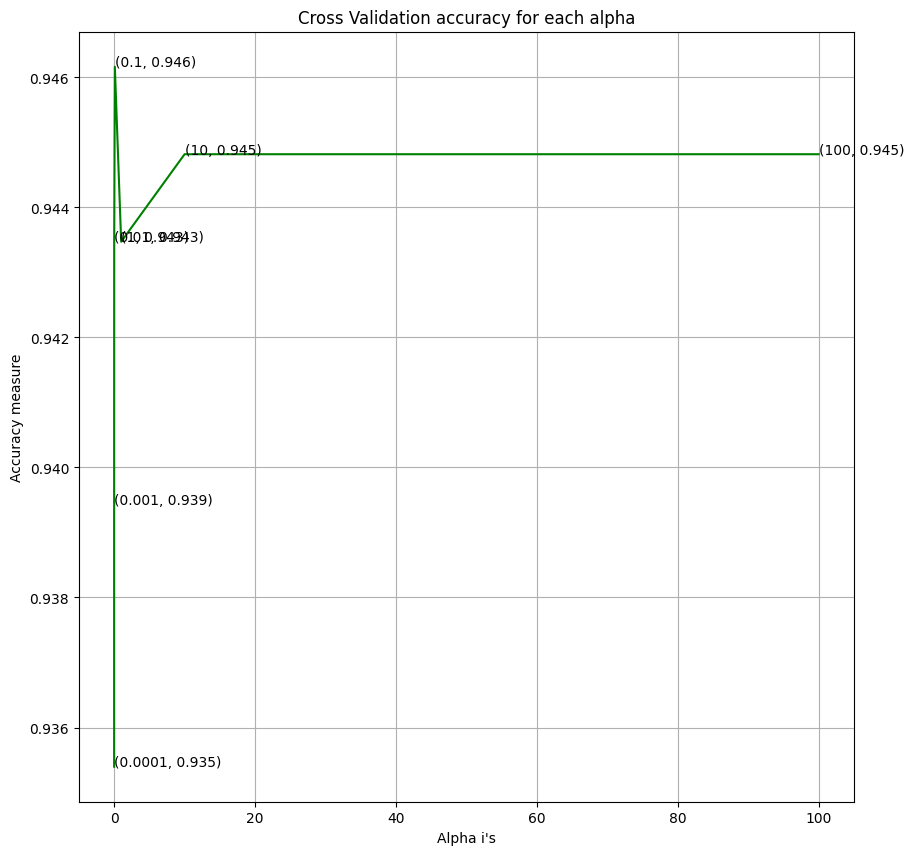

In [19]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.6380894060012248
Precision on test data for final baseline model 0.592831541218638
Recall on test data for final baseline model 0.9729411764705882
-------------------------------------------------- Confusion matrix --------------------------------------------------


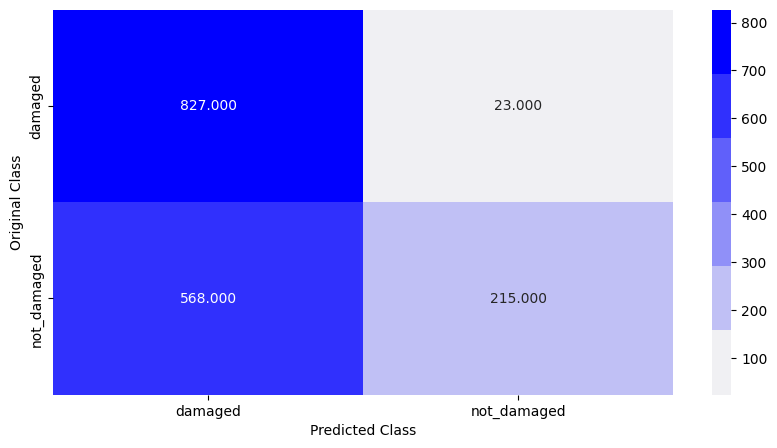

In [20]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage1_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
precision,recall = compute_precision_recall(y_test,predict_y)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_test,predict_y,stage1_class_labels)

In [21]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage1_baseline'], 'Accuracy':['0.930'], 'Precision':['0.923'], 'Recall':['0.940']})], ignore_index=True)


### Stage 2

In [22]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

In [23]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.
179/179 [==============================] - 45s 252ms/step


In [24]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [25]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [26]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [04:02<24:16, 242.75s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

Accuracy for alpha 0.0001 is  0.6962305986696231
Accuracy for alpha 0.001 is  0.6895787139689579
Accuracy for alpha 0.01 is  0.6962305986696231
Accuracy for alpha 0.1 is  0.6829268292682927
Accuracy for alpha 1 is  0.6740576496674058
Accuracy for alpha 10 is  0.6873614190687362
Accuracy for alpha 100 is  0.6851441241685144


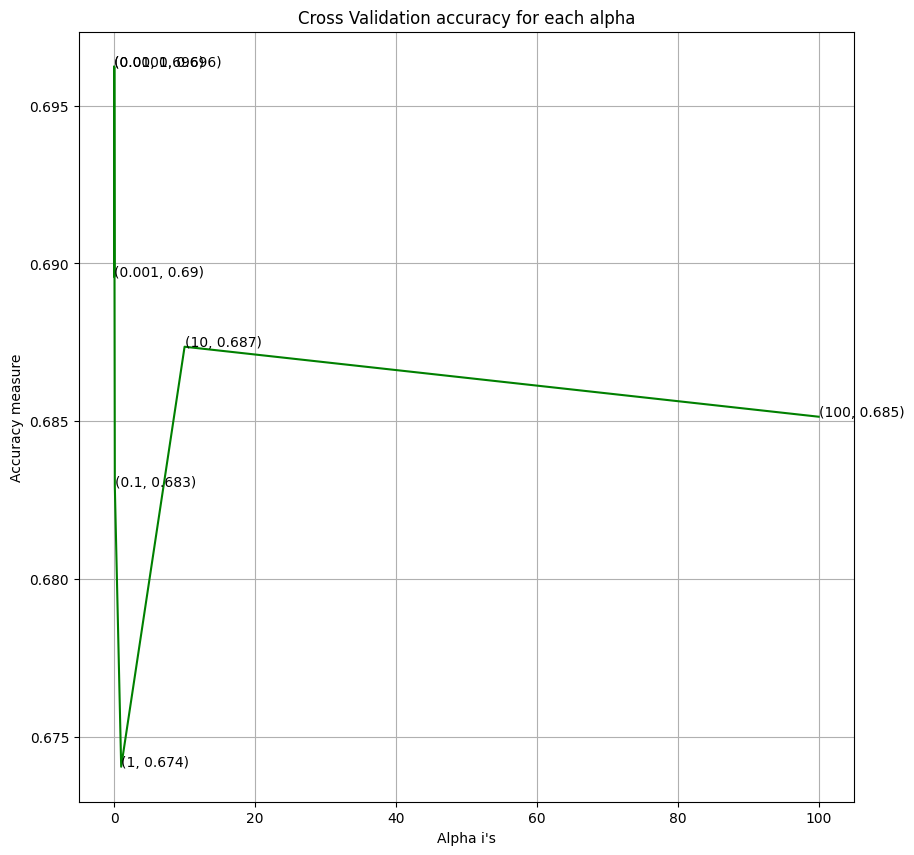

In [27]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.2681564245810056
Average Precision is 0.2764690982776089
Average Recall is 0.2856210308087965
-------------------------------------------------- Confusion Matrix --------------------------------------------------


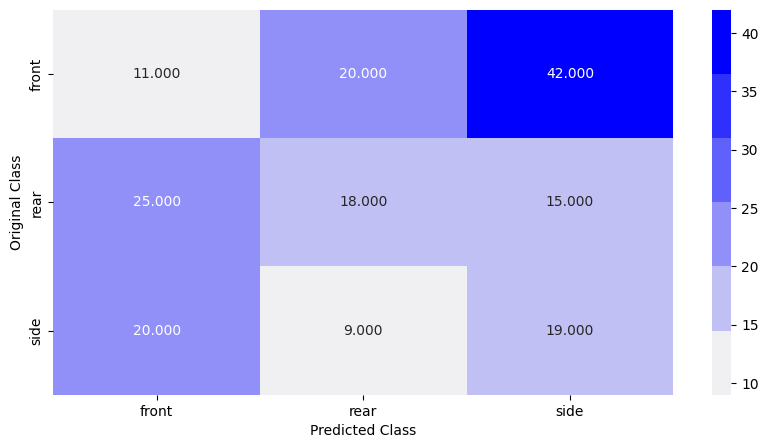

-------------------------------------------------- Precision Matrix --------------------------------------------------


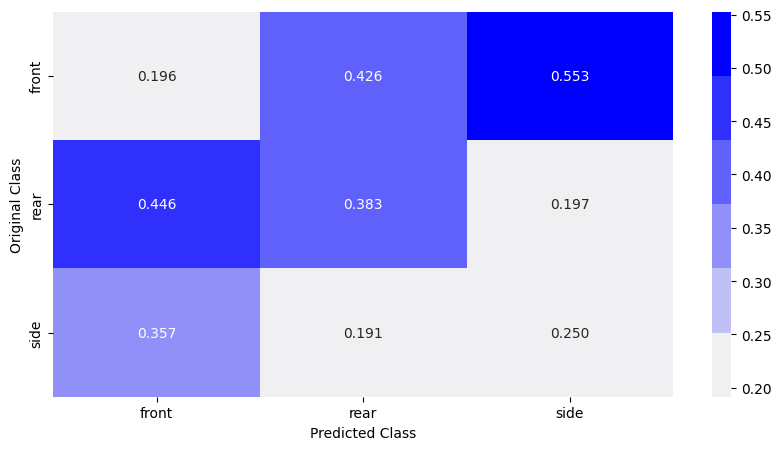

-------------------------------------------------- Recall Matrix --------------------------------------------------


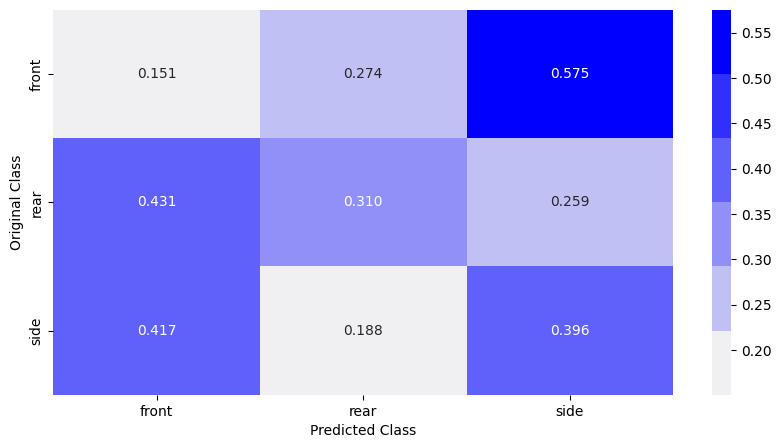

In [28]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model 
save_path = 'resnet/resnet_stage2_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage2_class_labels)

In [29]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage2_baseline'], 'Accuracy':['0.782'], 'Precision':['0.791'], 'Recall':['0.779']})], ignore_index=True)


### Stage 3

In [30]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

In [31]:
train_feat,test_feat,train_fd,test_fd = model_features(model_resnet,train_data_dir, test_data_dir)

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
171/171 [==============================] - 41s 240ms/step


In [32]:
train_df = pd.DataFrame(train_feat)
x_test = pd.DataFrame(test_feat)

In [33]:
train_class = target_feat(train_fd)
y_test = target_feat(test_fd)

In [34]:
#Dividing the datasets into train and CV for hyperparameter tuning.
x_train,x_cv,y_train,y_cv = train_test_split(train_df,train_class,stratify=train_class,test_size=0.20)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 14%|█▍        | 1/7 [03:51<23:06, 231.04s/it]/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for al

Accuracy for alpha 0.0001 is  0.8010204081632653
Accuracy for alpha 0.001 is  0.8061224489795918
Accuracy for alpha 0.01 is  0.8086734693877551
Accuracy for alpha 0.1 is  0.8061224489795918
Accuracy for alpha 1 is  0.8061224489795918
Accuracy for alpha 10 is  0.8086734693877551
Accuracy for alpha 100 is  0.8086734693877551


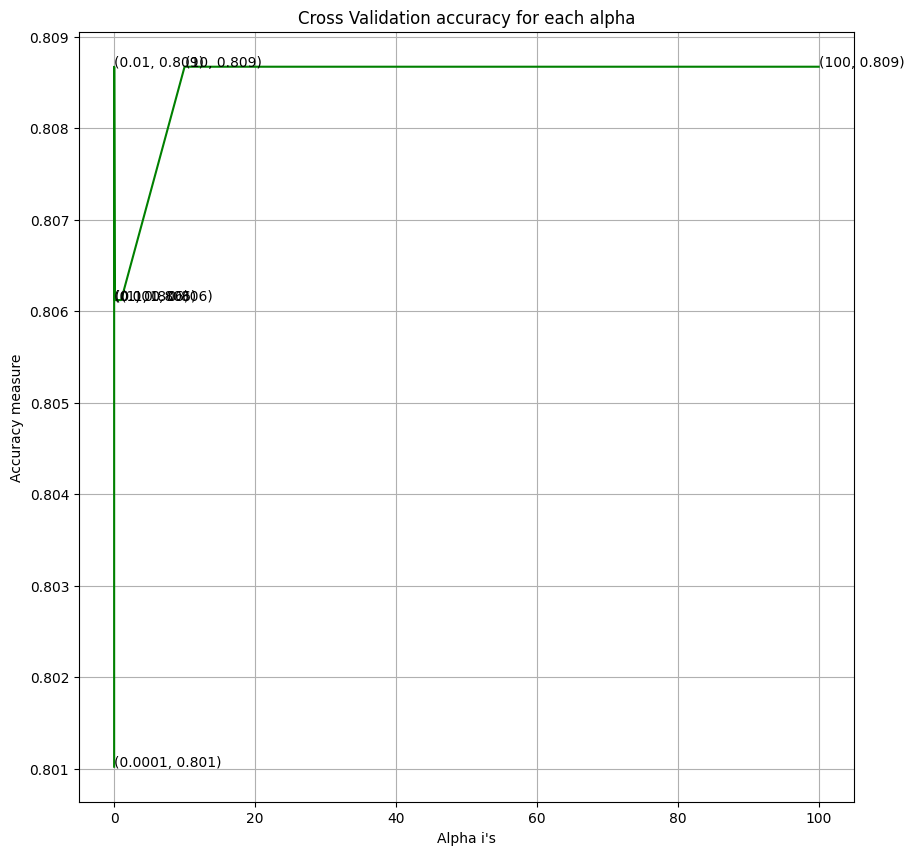

In [35]:
#Hyperparameter tuning
alpha = [10 ** x for x in range(-4, 3)]
cv_log_error_array=[] 
cv_acc_array = []
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight= 'balanced')
    logisticR.fit(x_train,y_train)
    cv_acc_array.append(accuracy_score(y_cv,logisticR.predict(x_cv)))
    
for i in range(len(cv_acc_array)):
    print('Accuracy for alpha '+str(alpha[i])+' is ',cv_acc_array[i])

best_alpha = np.argmax(cv_acc_array)
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(alpha, cv_acc_array,c='g')
for i, txt in enumerate(np.round(cv_acc_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_acc_array[i]))
plt.grid()
plt.title("Cross Validation accuracy for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Accuracy measure")
plt.show()

/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on test data for final baseline model 0.6549707602339181
Average Precision is 0.6533513270355376
Average Recall is 0.6398098633392751
-------------------------------------------------- Confusion Matrix --------------------------------------------------


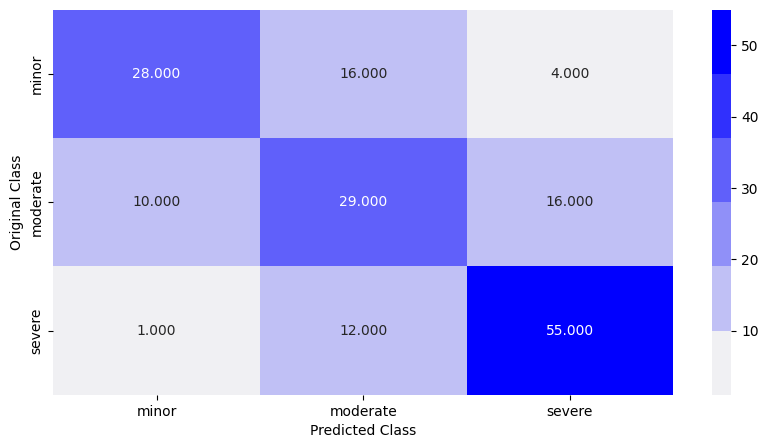

-------------------------------------------------- Precision Matrix --------------------------------------------------


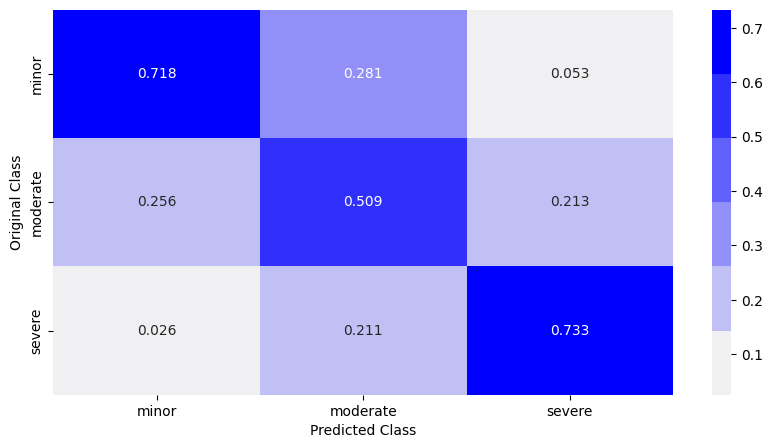

-------------------------------------------------- Recall Matrix --------------------------------------------------


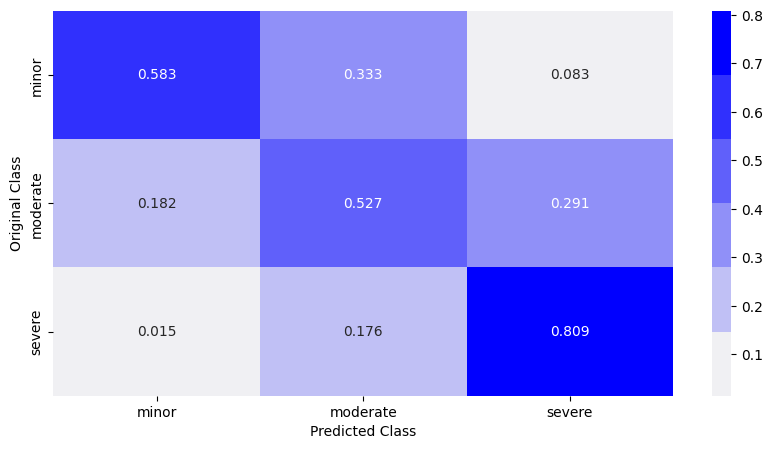

In [36]:
#Final model using best paramaters from hyperparameter tuning.
base_final=LogisticRegression(penalty='l2',C=alpha[best_alpha])
base_final.fit(x_train,y_train)

#saving the model
save_path = 'resnet/resnet_stage3_baseline.sav'
pickle.dump(base_final,open(save_path,'wb'))

#Predcitions and visualization of Confusion matrix
predict_y = base_final.predict(x_test)
print ('Accuracy on test data for final baseline model',accuracy_score(y_test, predict_y))
multiclass_confusion_matrix(y_test,predict_y,stage3_class_labels)

In [37]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage3_baseline'], 'Accuracy':['0.637'], 'Precision':['0.633'], 'Recall':['0.621']})], ignore_index=True)


### CNN (Training FC layers only)

In [38]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)
    resnet = non_trainable(resnet)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [39]:
model = create_model(1,'sigmoid')

In [40]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [42]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [43]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage1_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [44]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [45]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.


In [46]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

460/460 [==============================] - ETA: 0s - loss: 9.1496 - accuracy: 0.5064
Epoch 1: val_accuracy improved from -inf to 0.44181, saving model to resnet/resnet_stage1_fc-0.442.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


460/460 [==============================] - 381s 822ms/step - loss: 9.1496 - accuracy: 0.5064 - val_loss: 2.1485 - val_accuracy: 0.4418


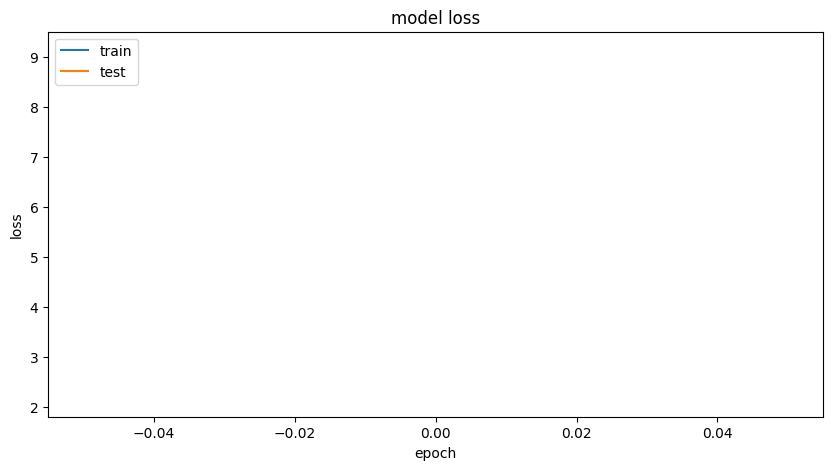

The loss for final model is  2.148470878601074


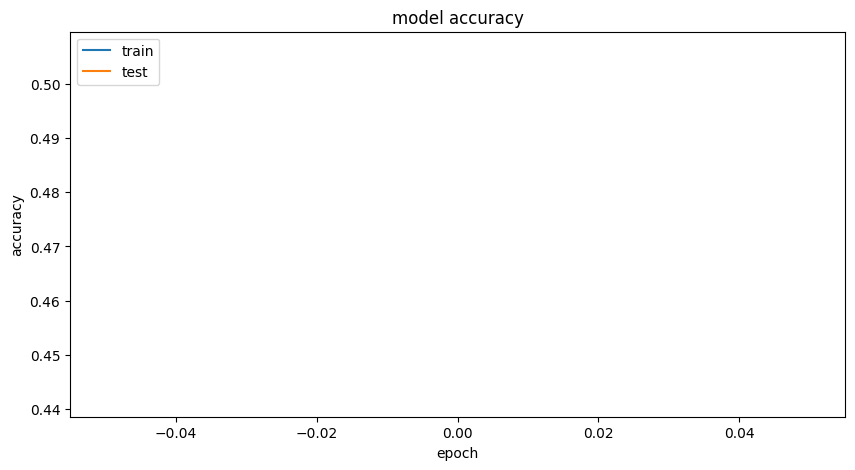

The accuracy for final model is  0.44181033968925476


In [47]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [48]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1633 images belonging to 2 classes.


In [50]:
best_model = load_model('resnet/resnet_stage1_fc-0.442.hdf5')

In [51]:
y_pred = best_model.predict(x_test)

1633/1633 [==============================] - 185s 113ms/step


In [52]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model 1.0
Recall on test data for final baseline model 0.0035294117647058825
-------------------------------------------------- Confusion matrix --------------------------------------------------


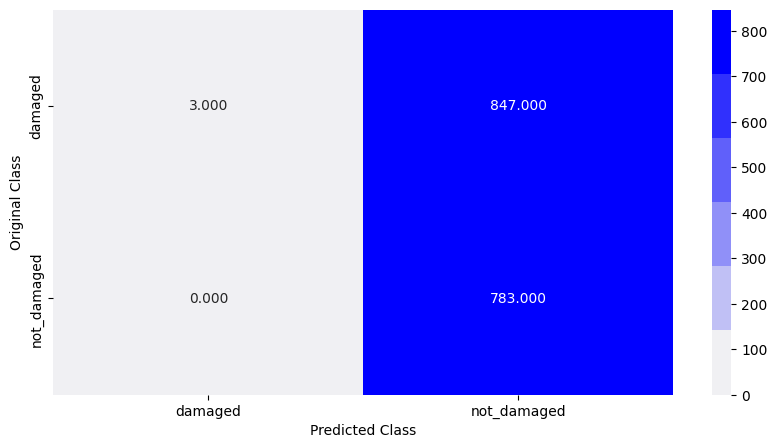

In [53]:
precision,recall = compute_precision_recall(y_true,y_predicted)
print ('Precision on test data for final baseline model',precision)
print ('Recall on test data for final baseline model',recall)
binary_confusion_matrix(y_true,y_predicted,stage1_class_labels)

In [54]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage1 FC'], 'Accuracy':['0.933'], 'Precision':['0.938'], 'Recall':['0.926']})], ignore_index=True)


### Stage 2

In [55]:
model = create_model(3,'softmax')

In [56]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [57]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [58]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage2_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [60]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [61]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [62]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

247/246 [==============================] - ETA: 0s - loss: 4617291694080.0000 - accuracy: 0.3078
Epoch 1: val_accuracy improved from -inf to 0.40782, saving model to resnet/resnet_stage2_fc-0.408.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 128s 514ms/step - loss: 4617291694080.0000 - accuracy: 0.3078 - val_loss: 1895.6395 - val_accuracy: 0.4078


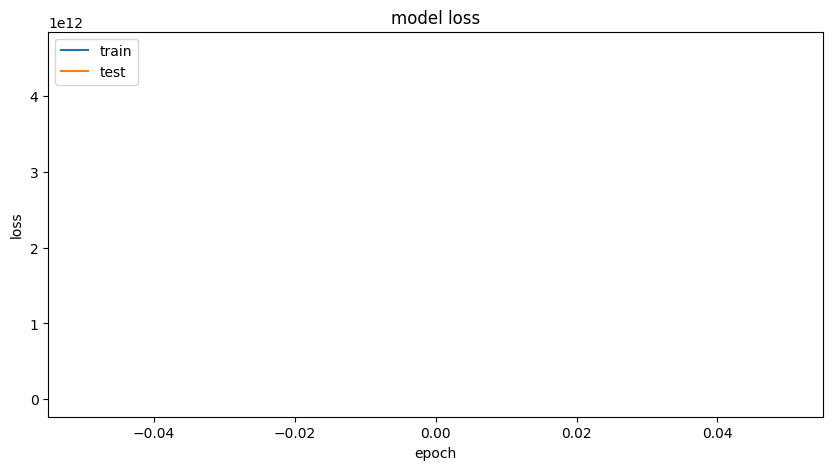

The loss for final model is  1895.6395263671875


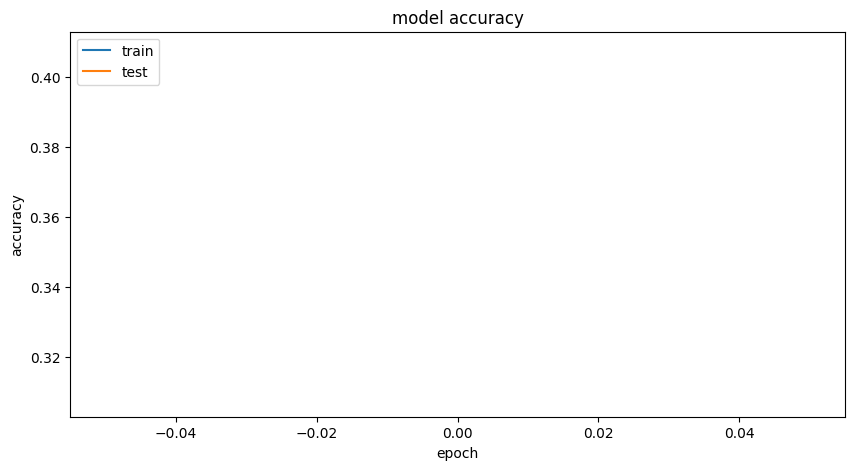

The accuracy for final model is  0.4078212380409241


In [63]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [64]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [65]:
best_model = load_model('resnet/resnet_stage2_fc-0.408.hdf5')

In [66]:
y_pred = best_model.predict(x_test)

179/179 [==============================] - 20s 110ms/step


In [67]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is nan
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_46578/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


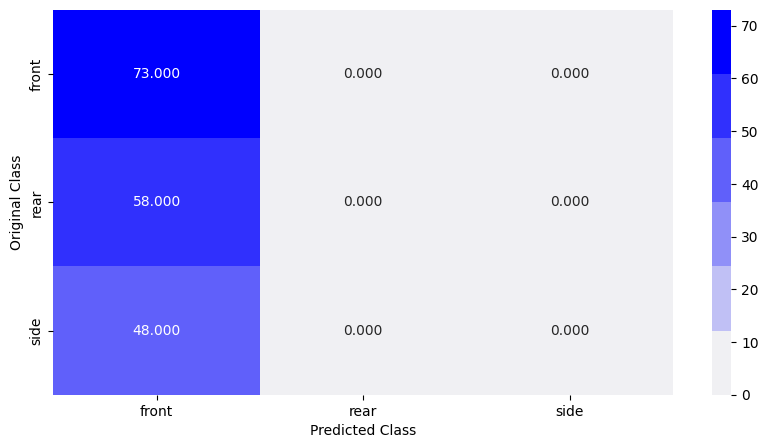

-------------------------------------------------- Precision Matrix --------------------------------------------------


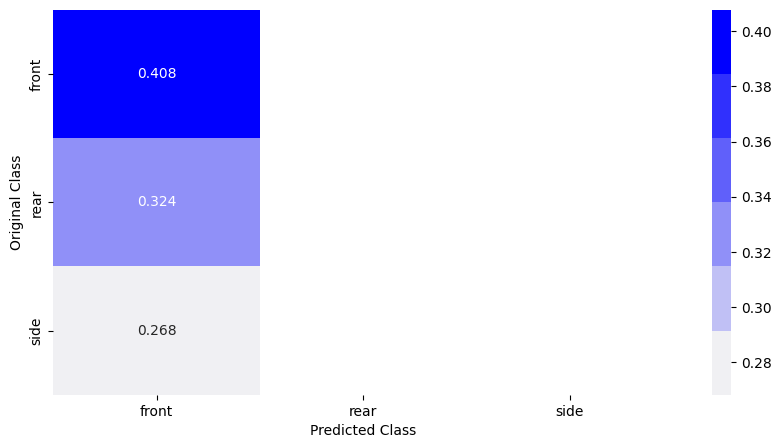

-------------------------------------------------- Recall Matrix --------------------------------------------------


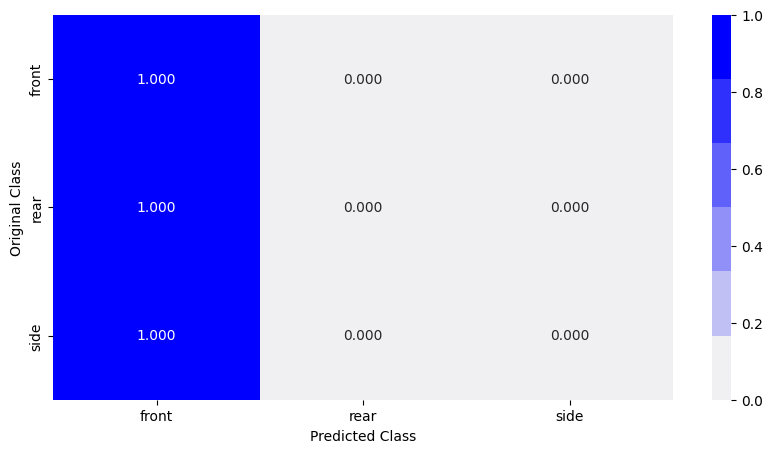

In [68]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [69]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage2 FC'], 'Accuracy':['0.771'], 'Precision':['0.788'], 'Recall':['0.759']})], ignore_index=True)


### Stage 3

In [70]:
model = create_model(3,'softmax')

In [71]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [72]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [73]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [74]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage3_fc-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [75]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [76]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [77]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

245/244 [==============================] - ETA: 0s - loss: nan - accuracy: 0.3075
Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to resnet/resnet_stage3_fc-0.281.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/244 [==============================] - 200s 809ms/step - loss: nan - accuracy: 0.3075 - val_loss: nan - val_accuracy: 0.2807


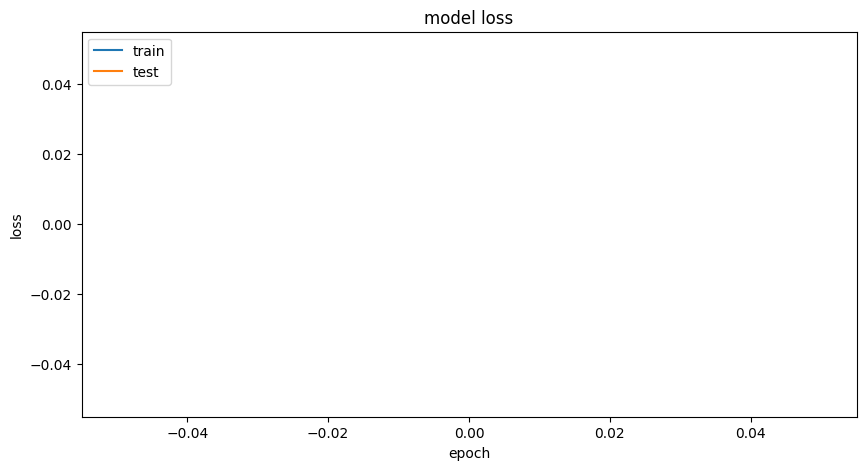

The loss for final model is  nan


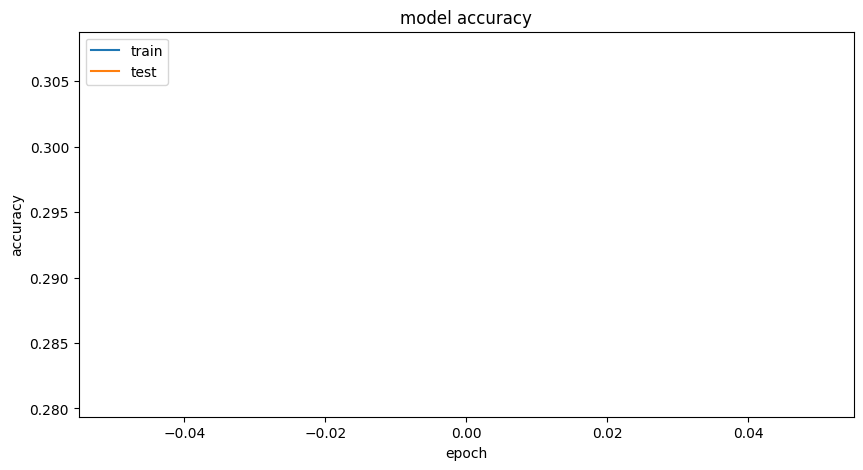

The accuracy for final model is  0.28070175647735596


In [78]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [79]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [81]:
best_model = load_model('resnet/resnet_stage3_fc-0.281.hdf5')

In [82]:
y_pred = best_model.predict(x_test)

171/171 [==============================] - 34s 188ms/step


In [83]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    n = np.argmax(i)
if n == 0:
    y_predicted.append('minor')
elif n== 1:
    y_predicted.append('moderate')
elif n == 2:
    y_predicted.append('severe')

Average Precision is 0.3333333333333333
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


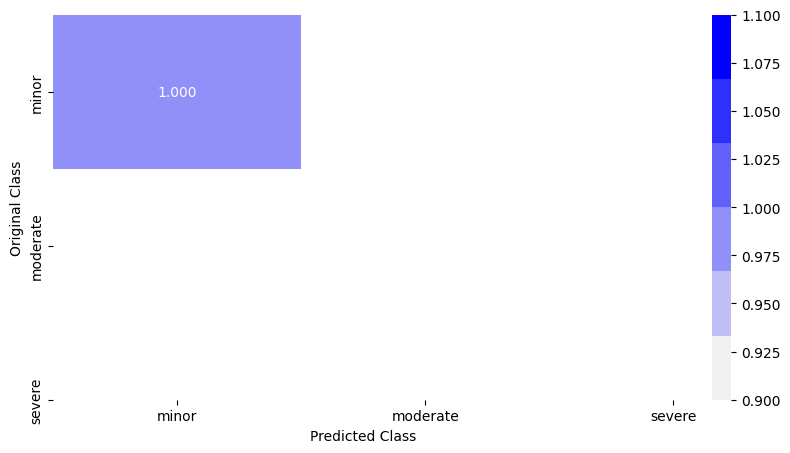

-------------------------------------------------- Precision Matrix --------------------------------------------------


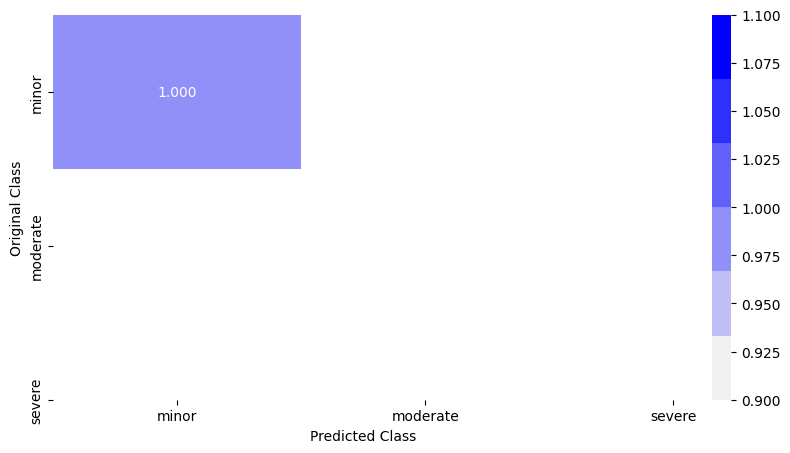

-------------------------------------------------- Recall Matrix --------------------------------------------------


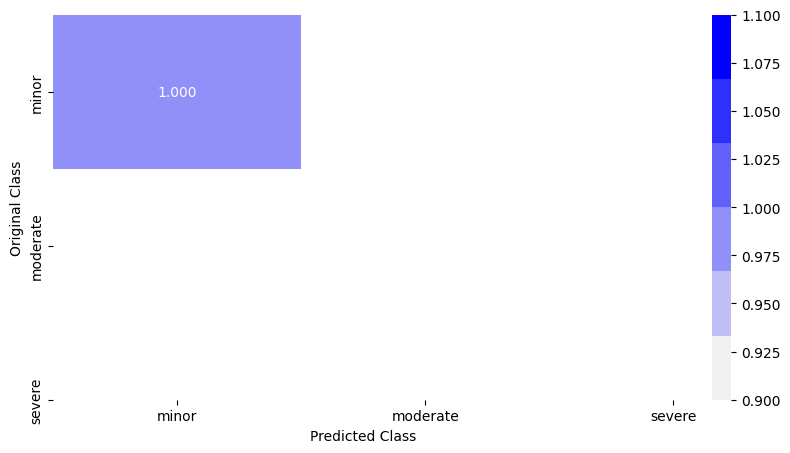

In [84]:
multiclass_confusion_matrix(y_true[:1], y_predicted[:1], stage3_class_labels)


In [85]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage3 FC'], 'Accuracy':['0.643'], 'Precision':['0.628'], 'Recall':['0.630']})], ignore_index=True)


### CNN (Training All layers only)

In [86]:
def create_model(n_classes,output_activation):
    os.environ['PYTHONHASHSEED'] = '0'
    tf.keras.backend.clear_session()

    ## Set the random seed values to regenerate the model.
    np.random.seed(0)
    rn.seed(0)

    #Input layer
    input_layer = Input(shape=(256,256,3),name='Input_Layer')

    #Adding pretrained model
    resnet = applications.ResNet50(include_top=False,weights='imagenet',input_tensor = input_layer)

    #Flatten
    flatten = Flatten(data_format='channels_last',name='Flatten')(resnet.output)

    #FC layer
    FC1 = Dense(units=512,activation='relu',name='FC1')(flatten)

    #FC layer
    FC2 = Dense(units=256,activation='relu',name='FC2')(FC1)

    #Dropout layer
    droput1 = Dropout(0.5)(FC2)

    #output layer
    Out = Dense(units=n_classes,activation=output_activation,name='Output')(droput1)

    #Creating the Model
    model = Model(inputs=input_layer,outputs=Out)

    return model

### Stage 1

In [87]:
model = create_model(1,'sigmoid')

In [88]:
#Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [89]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [90]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [91]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage1_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [92]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [93]:
train_data_dir = 'data_augmentation_1/data_1/train'
test_data_dir = 'data_augmentation_1/data_1/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size, class_mode = "binary")

n_validation_steps = 460/batch_size
n_steps_epoch = 3680/batch_size

Found 3711 images belonging to 2 classes.
Found 1633 images belonging to 2 classes.


In [94]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

460/460 [==============================] - ETA: 0s - loss: nan - accuracy: 0.4958
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to resnet/resnet_stage1_all-0.562.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


460/460 [==============================] - 1409s 3s/step - loss: nan - accuracy: 0.4958 - val_loss: nan - val_accuracy: 0.5625


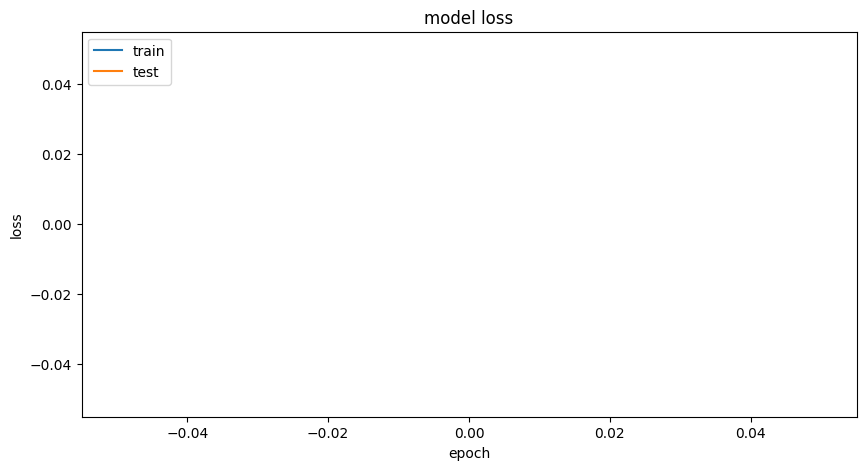

The loss for final model is  nan


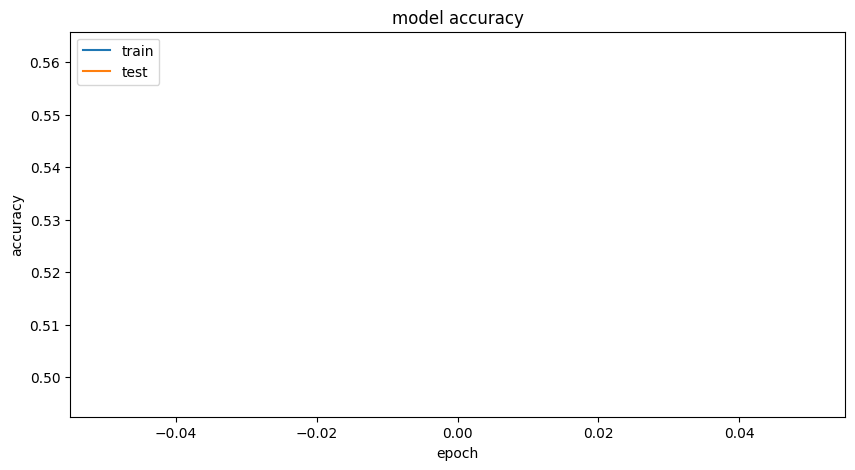

The accuracy for final model is  0.5625


In [95]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [96]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1, class_mode = "binary",shuffle = False)

Found 1633 images belonging to 2 classes.


In [97]:
best_model = load_model('resnet/resnet_stage1_all-0.562.hdf5')

In [98]:
y_pred = best_model.predict(x_test)

1633/1633 [==============================] - 289s 176ms/step


In [99]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  if i <= .5:
    y_predicted.append('damaged')
  elif i > .5:
    y_predicted.append('not_damaged')

Precision on test data for final baseline model: 0.5205143906919779
Recall on test data for final baseline model: 1.0
-------------------------------------------------- Confusion matrix --------------------------------------------------


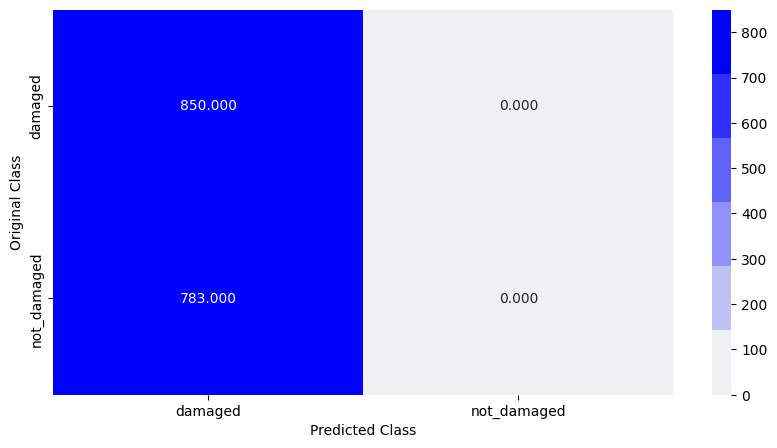

In [100]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
    n = np.argmax(i)
    if n == 0:
        y_predicted.append('damaged')
    elif n == 1:
        y_predicted.append('not_damaged')

precision, recall = compute_precision_recall(y_true[:1633], y_predicted[:1633])
print('Precision on test data for final baseline model:', precision)
print('Recall on test data for final baseline model:', recall)
binary_confusion_matrix(y_true[:1633], y_predicted[:1633], stage1_class_labels)


In [101]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage1 all'], 'Accuracy':['0.961'], 'Precision':['0.945'], 'Recall':['0.978']})], ignore_index=True)


### Stage 2

In [102]:
model = create_model(3,'softmax')

In [103]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [104]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [105]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [106]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage2_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [107]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [108]:
train_data_dir = 'data_augmentation_1/data_2/train'
test_data_dir = 'data_augmentation_1/data_2/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 179/batch_size
n_steps_epoch = 1970/batch_size

Found 2252 images belonging to 3 classes.
Found 179 images belonging to 3 classes.


In [109]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

247/246 [==============================] - ETA: -2s - loss: nan - accuracy: 0.3676
Epoch 1: val_accuracy improved from -inf to 0.40782, saving model to resnet/resnet_stage2_all-0.408.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


246/246 [==============================] - 951s 4s/step - loss: nan - accuracy: 0.3676 - val_loss: nan - val_accuracy: 0.4078


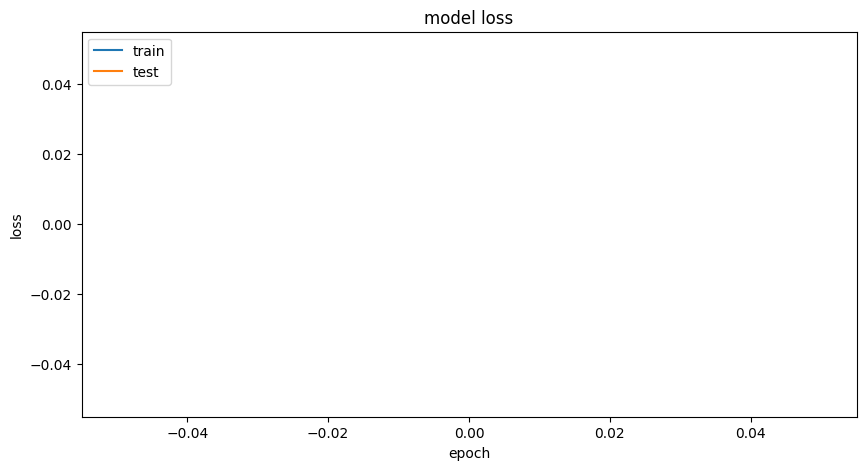

The loss for final model is  nan


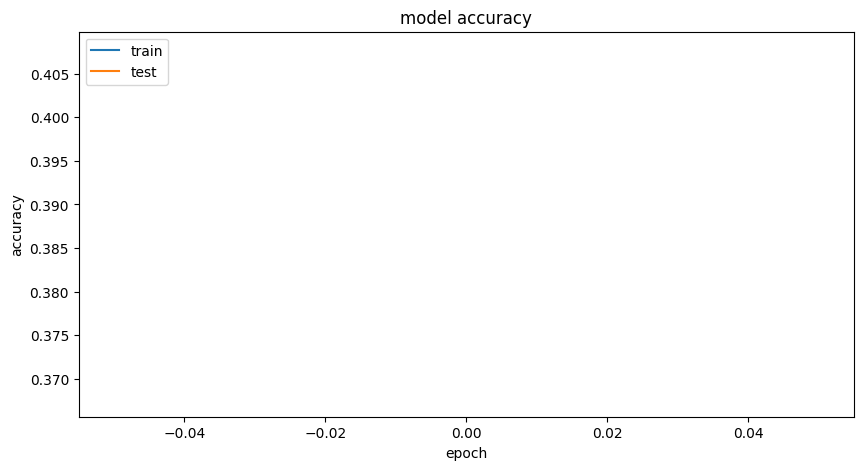

The accuracy for final model is  0.4078212380409241


In [110]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [111]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 179 images belonging to 3 classes.


In [112]:
best_model = load_model('resnet/resnet_stage2_all-0.408.hdf5')

In [113]:
y_pred = best_model.predict(x_test)

179/179 [==============================] - 45s 241ms/step


In [114]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('front')
  elif n== 1:
    y_predicted.append('rear')
  elif n == 2:
    y_predicted.append('side')

Average Precision is nan
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_46578/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


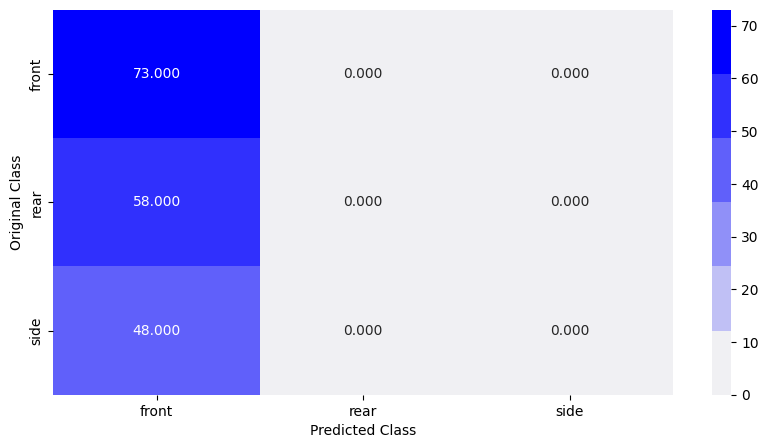

-------------------------------------------------- Precision Matrix --------------------------------------------------


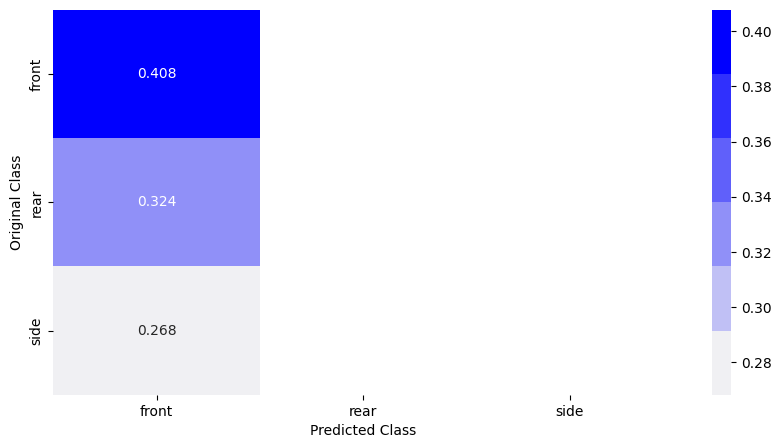

-------------------------------------------------- Recall Matrix --------------------------------------------------


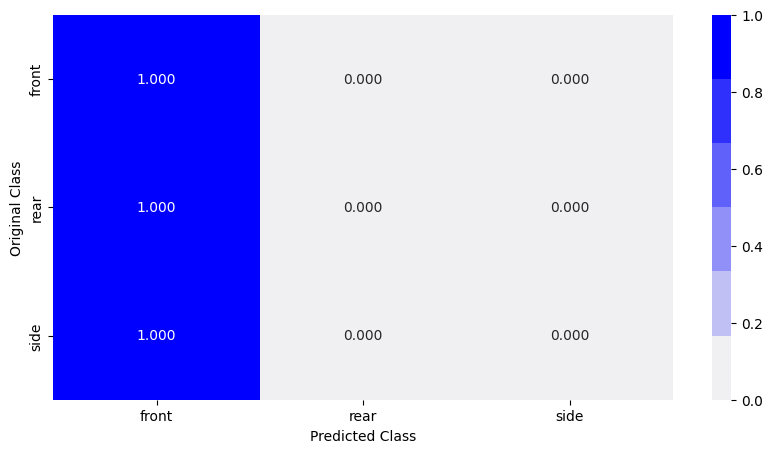

In [115]:
multiclass_confusion_matrix(y_true,y_predicted,stage2_class_labels)

In [116]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage2 all'], 'Accuracy':['0.749'], 'Precision':['0.762'], 'Recall':['0.740']})], ignore_index=True)


### Stage 3

In [117]:
model = create_model(3,'softmax')

In [118]:
#Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), metrics=["accuracy"])

In [119]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_Layer (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['Input_Layer[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [120]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True,rankdir='TB', expand_nested=False, dpi=96)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [121]:
#Model saving based on validation accuracy score
filepath="resnet/resnet_stage3_all-{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='auto')

In [122]:
traindatagen = ImageDataGenerator()
testdatagen = ImageDataGenerator()

In [123]:
train_data_dir = 'data_augmentation_1/data_3/train'
test_data_dir = 'data_augmentation_1/data_3/test'

train_generator = traindatagen.flow_from_directory(train_data_dir,target_size = (256,256),batch_size = batch_size)
test_generator = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = batch_size)

n_validation_steps = 171/batch_size
n_steps_epoch = 1958/batch_size

Found 1958 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [124]:
model.fit(train_generator ,validation_data = test_generator,validation_steps = n_validation_steps,steps_per_epoch=n_steps_epoch,epochs=1,callbacks=[checkpoint])

245/244 [==============================] - ETA: 0s - loss: nan - accuracy: 0.2865
Epoch 1: val_accuracy improved from -inf to 0.28070, saving model to resnet/resnet_stage3_all-0.281.hdf5


/Users/tuhinaww/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


244/244 [==============================] - 688s 3s/step - loss: nan - accuracy: 0.2865 - val_loss: nan - val_accuracy: 0.2807


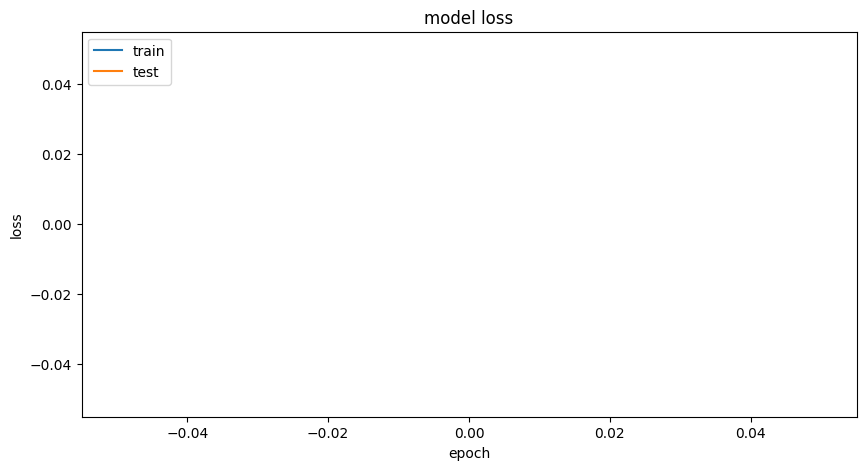

The loss for final model is  nan


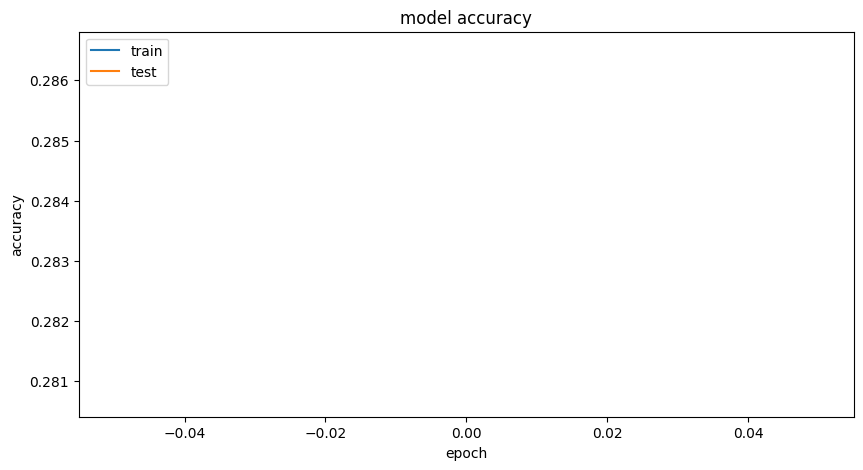

The accuracy for final model is  0.28070175647735596


In [125]:
for i in ['loss','accuracy']:
  plot_metrics(model,i)

In [126]:
x_test = testdatagen.flow_from_directory(test_data_dir,target_size = (256,256),batch_size = 1,shuffle = False)

Found 171 images belonging to 3 classes.


In [127]:
best_model = load_model('resnet/resnet_stage3_all-0.281.hdf5')

In [128]:
y_pred = best_model.predict(x_test)

171/171 [==============================] - 24s 137ms/step


In [129]:
y_true = target_feat(x_test)
y_predicted = []
for i in y_pred:
  n = np.argmax(i)
  if n == 0:
    y_predicted.append('minor')
  elif n== 1:
    y_predicted.append('moderate')
  elif n == 2:
    y_predicted.append('severe')

Average Precision is nan
Average Recall is 0.3333333333333333
-------------------------------------------------- Confusion Matrix --------------------------------------------------


/var/folders/7w/7lp03gcd6ss9lpq43k131wfh0000gn/T/ipykernel_46578/1789923900.py:3: RuntimeWarning: invalid value encountered in divide
  Pm = (Cm/Cm.sum(axis = 0))


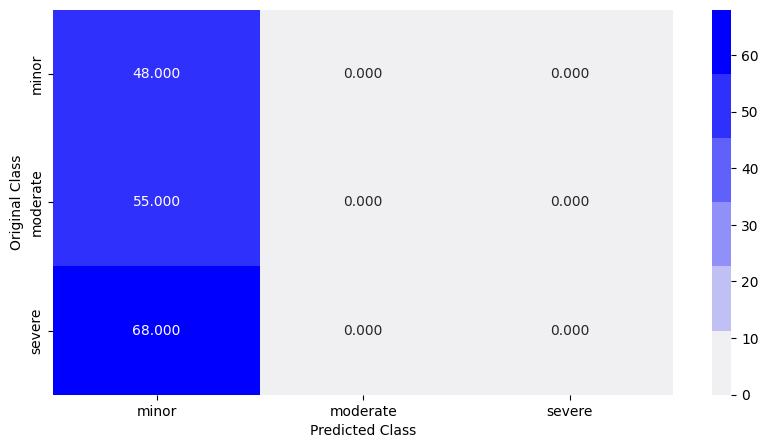

-------------------------------------------------- Precision Matrix --------------------------------------------------


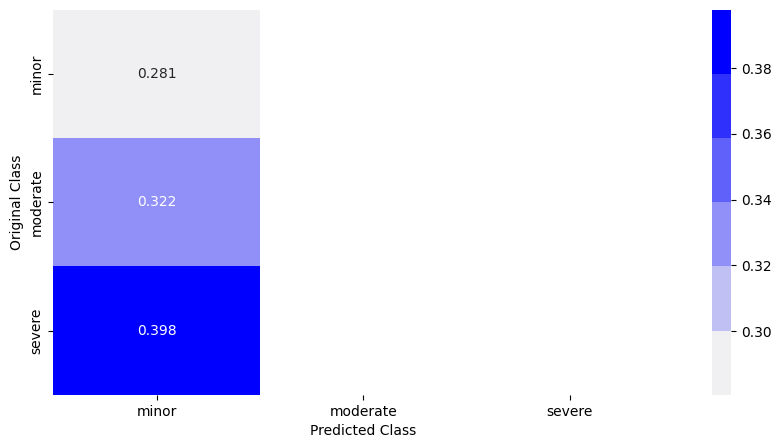

-------------------------------------------------- Recall Matrix --------------------------------------------------


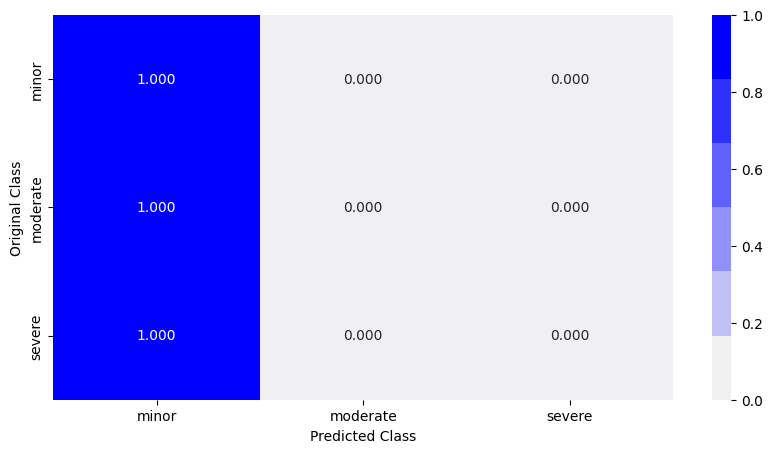

In [130]:
multiclass_confusion_matrix(y_true,y_predicted,stage3_class_labels)

In [131]:
resnet_scores = pd.concat([resnet_scores, pd.DataFrame({'Model':['Resnet_stage3 all'], 'Accuracy':['0.643'], 'Precision':['0.635'], 'Recall':['0.633']})], ignore_index=True)


In [132]:
resnet_scores.to_csv('resnet_scores.csv',index=False)